After discussing with my mentor, we've decided that it's best we take an approach of assessing which datasets to use, rather than evaluating the models themselves. Given that the goal of the final project is to compare the performance of various models, it is likely we will include a variety of models regardless of their performance. As such, we will focus this exercise on examining the performance of various datasets.

Dataset 1: Time-series stock data (daily)

Dataset 2: Financial news + technical data

Dataset 3: Combination of time-series data + monthly production values (https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/09_time_series_models/02_arima_models.ipynb)

Dataset 4: Quandl? https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/data/create_datasets.ipynb

Approaches: 
1. RNN: See existing research
2. ARIMA: https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/09_time_series_models/02_arima_models.ipynb
3. K-means: https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/13_unsupervised_learning/03_clustering_algorithms/02_kmeans_implementation.ipynb
4. Gradient boosting: see stefan jansen

<h4> Section 0: Imports </h4>

In [3]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


<h4> Section 1: Time-series data from FRED (Federal Reserve Bank's Data Service) </h4>



In [5]:
sns.set_style('whitegrid')
np.random.seed(42)

results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

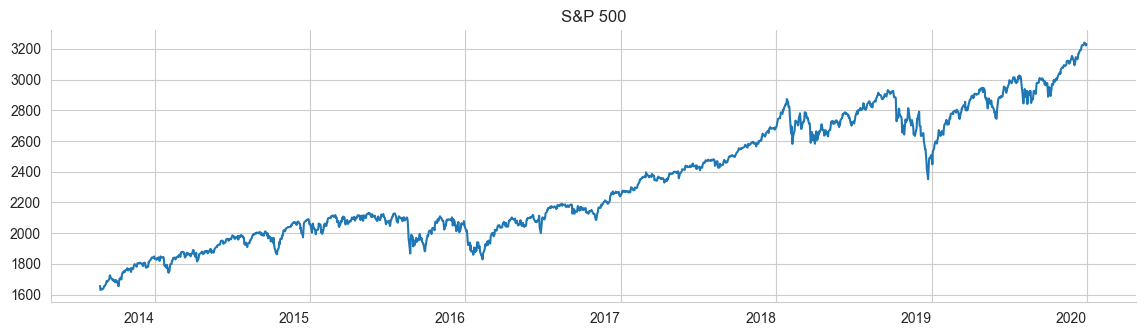

In [10]:
sp500 = web.DataReader('SP500', 'fred', start='2010', end='2020').dropna()
ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [13]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import requests
from io import BytesIO
from zipfile import ZipFile, BadZipFile

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.datasets import fetch_openml

pd.set_option('display.expand_frame_repr', False)

In [14]:
DATA_STORE = Path('assets.h5')

In [16]:
df = pd.read_csv('data/wiki_stocks.csv')
# no longer needed
# df = pd.concat([df.loc[:, 'code'].str.strip(),
#                 df.loc[:, 'name'].str.split('(', expand=True)[0].str.strip().to_frame('name')], axis=1)

print(df.info)
with pd.HDFStore(DATA_STORE) as store:
    store.put('quandl/wiki/stocks', df)

<bound method DataFrame.info of      ticker                                               name
0         A  Agilent Technologies Inc. (A) Prices, Dividend...
1        AA  Alcoa Inc. (AA) Prices, Dividends, Splits and ...
2       AAL  American Airlines Group Inc. (AAL) Prices, Div...
3      AAMC  Altisource Asset Management (AAMC) Prices, Div...
4       AAN  Aaron's Inc. (AAN) Prices, Dividends, Splits a...
...     ...                                                ...
3176   ZNGA  Zynga Inc. (ZNGA) Prices, Dividends, Splits an...
3177   ZOES  Zoe's Kitchen Inc (ZOES) Prices, Dividends, Sp...
3178    ZQK  Quiksilver Inc. (ZQK) Prices, Dividends, Split...
3179    ZTS  Zoetis Inc (ZTS) Prices, Dividends, Splits and...
3180   ZUMZ  Zumiez Inc. (ZUMZ) Prices, Dividends, Splits a...

[3181 rows x 2 columns]>


In [24]:
df = (pd.read_csv('data/wiki_prices.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())

print(df.info)

<bound method DataFrame.info of                      open    high     low   close      volume  ex-dividend  split_ratio   adj_open   adj_high    adj_low  adj_close    adj_volume
date       ticker                                                                                                                                
1962-01-02 ARNC     65.56   65.75   65.38   65.38      5600.0          0.0          1.0   3.458163   3.468185   3.448668   3.448668  4.480000e+04
           BA       50.88   50.88   50.00   50.00     11595.0          0.0          1.0   0.887160   0.887160   0.871816   0.871816  3.521981e+05
           CAT      38.50   38.87   38.12   38.50     13600.0          0.0          1.0   1.578370   1.593539   1.562791   1.578370  1.632000e+05
           DD      241.50  244.25  241.50  241.50      2000.0          0.0          1.0   4.718414   4.772144   4.718414   4.718414  3.600000e+04
           DIS      37.25   38.50   37.25   37.25      2098.0          0.0          1.0   0.

In [60]:
def get_data(start_date, end_date, ticker, df):
    idx = pd.IndexSlice
    new_df = df.loc[idx[start_date:end_date, ticker], :]
    return new_df

In [62]:
DEFAULT_START = '2008-01-01'
DEFAULT_END = '2018-01-01'

AAPL_df = get_data(DEFAULT_START, DEFAULT_END, 'AAPL', df)
AAPL_df.head(5)

,,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
date,ticker,,,,,,,,,,,,
2008-01-02,AAPL,199.27,200.26,192.55,194.84,38542100.0,0.0,1.0,25.608972,25.736201,24.745359,25.039656,269794700.0
2008-01-03,AAPL,195.41,197.39,192.69,194.93,30073800.0,0.0,1.0,25.112909,25.367366,24.763351,25.051222,210516600.0
2008-01-04,AAPL,191.45,193.00,178.89,180.05,51994000.0,0.0,1.0,24.603993,24.803190,22.989858,23.138934,363958000.0
2008-01-07,AAPL,181.25,183.60,170.23,177.64,74006900.0,0.0,1.0,23.293151,23.595159,21.876928,22.829216,518048300.0
2008-01-08,AAPL,180.14,182.46,170.80,171.25,54422000.0,0.0,1.0,23.150501,23.448653,21.950181,22.008012,380954000.0
